# Predict perssonel turnover rate

# 1. Introduction
Personnel resignation which occur frequently have a great impact on the company. This issue want to use basic personnel information and attendance-related information to classify whether personnel will resign.

In [356]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [169]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

# 2. About the dataset
There are ten projects information and the total work hour of personnel by month.

In [170]:
df = pd.read_csv('TMP_HCM_VARIABLES_v20210223_add5.csv')
df.head()

C:\Users\10711304\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (1,5,7,92,93,121) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ROW_NUM,EMPLOYEE_ID,DATAYEAR,DATAMONTH,DEPARTMENT_ID_LAST,LOCATION_CODE,JOB_FUNCTION,SUPERVISOR,JOB_TITLE,AGE,...,JOB_CATEGORY_MTH_OLD,JOB_CATEGORY_MTH_NEW,JOB_FUNCTION_OLD,JOB_FUNCTION_NEW,JOB_FUNCTION_CHANGE,JOB_FUNCTION_MTH_OLD,JOB_FUNCTION_MTH_NEW,JOB_DESC_OLD,JOB_DESC_NEW,JOB_DESC_CHANGE
0,1027986,10001111,2011,3,P2P100,006,M5,10001113.0,11B,39.0,...,3,3,M5,LO,1.0,3,3,???,?????????,1.0
1,1027989,10001111,2011,4,P2P100,006,M5,10001113.0,11B,39.0,...,4,4,M5,LO,1.0,4,4,???,?????????,1.0
2,1027985,10001111,2011,5,P2A100,006,M5,10001113.0,11B,39.0,...,5,5,M5,LO,1.0,5,5,???,?????????,1.0
3,1027979,10001112,2011,1,P2S000,003,M2,10001101.0,10A,40.0,...,1,1,M2,BS,1.0,1,1,Source,???,1.0
4,1027984,10001112,2011,2,P2S000,003,M2,10001101.0,10A,40.0,...,2,2,M2,BS,1.0,2,2,Source,???,1.0


In [171]:
df.shape

(1031174, 138)

In [172]:
df.columns

Index(['ROW_NUM', 'EMPLOYEE_ID', 'DATAYEAR', 'DATAMONTH', 'DEPARTMENT_ID_LAST',
       'LOCATION_CODE', 'JOB_FUNCTION', 'SUPERVISOR', 'JOB_TITLE', 'AGE',
       ...
       'JOB_CATEGORY_MTH_OLD', 'JOB_CATEGORY_MTH_NEW', 'JOB_FUNCTION_OLD',
       'JOB_FUNCTION_NEW', 'JOB_FUNCTION_CHANGE', 'JOB_FUNCTION_MTH_OLD',
       'JOB_FUNCTION_MTH_NEW', 'JOB_DESC_OLD', 'JOB_DESC_NEW',
       'JOB_DESC_CHANGE'],
      dtype='object', length=138)

In [173]:
col = ['EMPLOYEE_ID','DATAYEAR','DATAMONTH','DEPARTMENT_ID_LAST','LOCATION_CODE',
       'AGE','EXPERIENCE_MONTH','MARITAL_STATUS','GRADE_MTH_NEW2',
       'LIFETIME_MONTH','RATIO_JUNIOR_LESS36','ABSENCE_HOURS',
       'JOB_TITLE','JOB_FUNCTION','JOB_FUNCTION_MTH_NEW','IS_ALIVE']

In [174]:
df2 = df[col]

In [197]:
df2.dtypes

EMPLOYEE_ID              object
DATAYEAR                  int64
DATAMONTH                 int64
DEPARTMENT_ID_LAST        int64
LOCATION_CODE             int32
AGE                     float64
EXPERIENCE_MONTH          int64
MARITAL_STATUS            int64
GRADE_MTH_NEW2            int64
LIFETIME_MONTH            int64
RATIO_JUNIOR_LESS36     float64
ABSENCE_HOURS           float64
JOB_TITLE                 int64
JOB_FUNCTION              int64
JOB_FUNCTION_MTH_NEW      int64
IS_ALIVE                  int64
dtype: object

In [176]:
df2.isnull().sum()

EMPLOYEE_ID              0
DATAYEAR                 0
DATAMONTH                0
DEPARTMENT_ID_LAST       0
LOCATION_CODE            0
AGE                     24
EXPERIENCE_MONTH         0
MARITAL_STATUS           0
GRADE_MTH_NEW2           0
LIFETIME_MONTH           0
RATIO_JUNIOR_LESS36      0
ABSENCE_HOURS            0
JOB_TITLE                0
JOB_FUNCTION             0
JOB_FUNCTION_MTH_NEW     0
IS_ALIVE                 0
dtype: int64

In [177]:
df2['AGE']=df2['AGE'].fillna(df2['AGE'].mean())

C:\Users\10711304\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [178]:
df2.describe()

,DATAYEAR,DATAMONTH,AGE,EXPERIENCE_MONTH,GRADE_MTH_NEW2,LIFETIME_MONTH,RATIO_JUNIOR_LESS36,ABSENCE_HOURS,JOB_FUNCTION_MTH_NEW,IS_ALIVE
count,1.031174e+06,1.031174e+06,1.031174e+06,1.031174e+06,1.031174e+06,1.031174e+06,1.031174e+06,1.031174e+06,1.031174e+06,1.031174e+06
mean,2.012726e+03,6.551966e+00,3.538676e+01,4.606561e+01,2.985221e+01,7.011004e+01,4.331378e-01,9.015610e+00,5.824668e+01,9.868955e-01
std,6.261224e+00,3.472985e+00,7.477950e+00,5.799812e+01,3.462951e+01,7.176940e+01,2.944448e-01,1.706704e+01,5.948039e+01,1.137223e-01
min,1.979000e+03,1.000000e+00,1.500000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-8.400000e+00,1.000000e+00,0.000000e+00
25%,2.010000e+03,4.000000e+00,3.000000e+01,0.000000e+00,8.000000e+00,1.700000e+01,2.000000e-01,0.000000e+00,1.500000e+01,1.000000e+00
50%,2.014000e+03,7.000000e+00,3.400000e+01,2.400000e+01,1.700000e+01,4.500000e+01,4.285714e-01,4.200000e+00,3.800000e+01,1.000000e+00
75%,2.018000e+03,1.000000e+01,4.000000e+01,7.300000e+01,3.800000e+01,1.000000e+02,6.470588e-01,1.260000e+01,8.200000e+01,1.000000e+00
max,2.021000e+03,1.200000e+01,6.900000e+01,4.400000e+02,3.430000e+02,5.010000e+02,1.000000e+00,7.056000e+02,4.150000e+02,1.000000e+00


# 3. Visualizing data
We are now going to visualize the data to find out relationship between each feature and target.

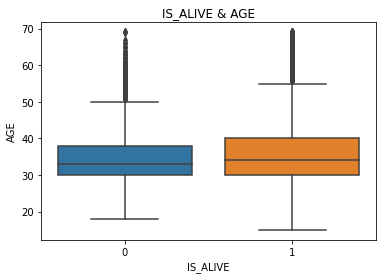

In [179]:
plt.title("IS_ALIVE & AGE") 
sns.boxplot(x="IS_ALIVE",y="AGE",data=df2) 
plt.show() # 

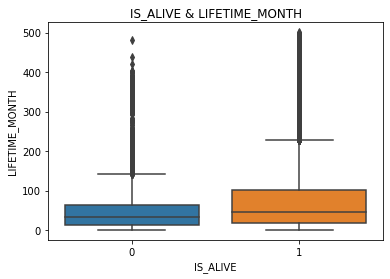

In [180]:
plt.title("IS_ALIVE & LIFETIME_MONTH") 
sns.boxplot(x="IS_ALIVE",y="LIFETIME_MONTH",data=df2) 
plt.show() # 

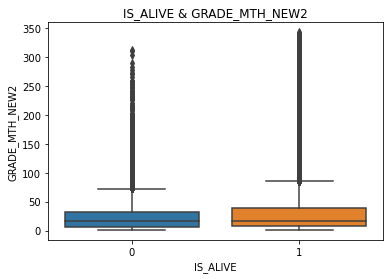

In [181]:
plt.title("IS_ALIVE & GRADE_MTH_NEW2") 
sns.boxplot(x="IS_ALIVE", y = "GRADE_MTH_NEW2", data = df2) 
plt.show() 

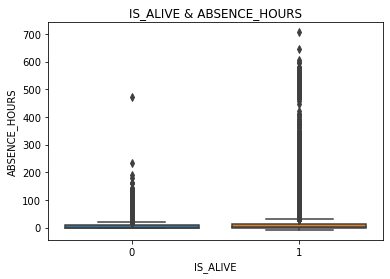

In [182]:
plt.title("IS_ALIVE & ABSENCE_HOURS") 
sns.boxplot(x="IS_ALIVE", y = "ABSENCE_HOURS", data = df2) 
plt.show() 

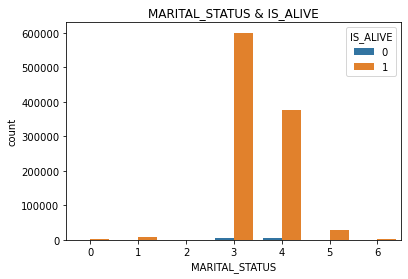

In [229]:
plt.title("MARITAL_STATUS & IS_ALIVE") 
sns.countplot(x="MARITAL_STATUS", hue = "IS_ALIVE", data = df2) 
plt.show() 

In [196]:
df2.corr().IS_ALIVE

DATAYEAR               -0.033869
DATAMONTH               0.001448
DEPARTMENT_ID_LAST      0.010823
LOCATION_CODE           0.013296
AGE                     0.019206
EXPERIENCE_MONTH       -0.014555
MARITAL_STATUS         -0.034358
GRADE_MTH_NEW2          0.014997
LIFETIME_MONTH          0.035568
RATIO_JUNIOR_LESS36    -0.023441
ABSENCE_HOURS           0.015098
JOB_TITLE              -0.024730
JOB_FUNCTION           -0.013794
JOB_FUNCTION_MTH_NEW    0.030374
IS_ALIVE                1.000000
Name: IS_ALIVE, dtype: float64

# 4.  Encoding categorical features

In [184]:
df3 = df2.drop(['EMPLOYEE_ID'],axis=1)
mask = df3.dtypes == np.object
categorical_cols = df3.columns[mask]

In [185]:
categorical_cols

Index(['DEPARTMENT_ID_LAST', 'LOCATION_CODE', 'MARITAL_STATUS', 'JOB_TITLE',
       'JOB_FUNCTION'],
      dtype='object')

In [186]:
# Determine how many extra columns would be created
num_ohc_cols = (df2[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

8813

In [188]:
num_ohc_cols

DEPARTMENT_ID_LAST    8453
JOB_TITLE              228
LOCATION_CODE           75
JOB_FUNCTION            55
MARITAL_STATUS           7
dtype: int64

In [194]:
le1 = LabelEncoder()
df2['DEPARTMENT_ID_LAST'] = le.fit_transform(df2.DEPARTMENT_ID_LAST)
le2 = LabelEncoder()
df2['JOB_TITLE'] = le.fit_transform(df2.JOB_TITLE)
le3 = LabelEncoder()
df2['LOCATION_CODE'] = le.fit_transform(df2.LOCATION_CODE.astype(str))
le4 = LabelEncoder()
df2['JOB_FUNCTION'] = le.fit_transform(df2.JOB_FUNCTION)
le5 = LabelEncoder()
df2['MARITAL_STATUS'] = le.fit_transform(df2.MARITAL_STATUS)

C:\Users\10711304\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\10711304\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\10711304\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

#  5. Defind target and features

In [339]:
train = df2[df2['DATAYEAR']<2020]
test = df2[df2['DATAYEAR']>=2020]

In [340]:
X_train = train.drop(['EMPLOYEE_ID','IS_ALIVE'],axis=1)
X_test  = test.drop(['EMPLOYEE_ID','IS_ALIVE'],axis=1)
y_train = train['IS_ALIVE']
y_test = test['IS_ALIVE']

# 6. UnderSampling

In [341]:
from imblearn.over_sampling import SMOTE
print("Before UpSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label '0': {} \n".format(sum(y_train==0)))

## Oversampling
#sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
#X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

## UnderSampling
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_res, y_train_res = undersample.fit_resample(X_train, y_train)

print("After UpSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After UpSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))

Before UpSampling, counts of label '1': 920735
Before UpSampling, counts of label '0': 12202 

After UpSampling, counts of label '1': 12202
After UpSampling, counts of label '0': 12202 



# 7. LogisticRegressionCV 

In [342]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train_res, y_train_res)
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train_res, y_train_res)

C:\Users\10711304\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\10711304\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\10711304\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\10711304\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\10711304\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

In [362]:
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [363]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)
metrics

C:\Users\10711304\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,lr,l1,l2
precision,0.973488,0.978868,0.978554
recall,0.986655,0.414121,0.430713
fscore,0.980027,0.572433,0.589072
accuracy,0.986655,0.414121,0.430713
auc,0.500000,0.580824,0.579074


In [351]:
cm_lr = confusion_matrix(y_test, y_pred.lr)
cm_l1 = confusion_matrix(y_test, y_pred.l1)
cm_l2 = confusion_matrix(y_test, y_pred.l2)
print('lr:\n{}'.format(cm_lr))
print('l1:\n{}'.format(cm_l1))
print('l2:\n{}'.format(cm_l2))

lr:
[[    0  1311]
 [    0 96926]]
l1:
[[  986   325]
 [57230 39696]]
l2:
[[  959   352]
 [55573 41353]]


#  8. DecisionTree

In [352]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train_res, y_train_res)

In [353]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [354]:
y_train_pred = dt.predict(X_train_res)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train_res, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,1.0,0.570589
precision,1.0,0.990291
recall,1.0,0.570373
f1,1.0,0.723840


In [355]:
cm_dt = confusion_matrix(y_test, y_test_pred)
print('dt:\n{}'.format(cm_dt))

dt:
[[  769   542]
 [41642 55284]]


# 9. GradientBoosting

In [358]:
param_grid = {'n_estimators': [15, 25, 50, 100, 200, 400],
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train_res, y_train_res)

In [359]:
# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(learning_rate=0.001, max_features=1,
                           n_estimators=400, random_state=42)

In [360]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.80      0.02      0.04     51194
           1       0.48      0.99      0.65     47043

    accuracy                           0.49     98237
   macro avg       0.64      0.51      0.35     98237
weighted avg       0.65      0.49      0.33     98237



In [361]:
cm_gb = confusion_matrix(y_test, y_pred)
print('gb:\n{}'.format(cm_gb))

gb:
[[ 1053   258]
 [50141 46785]]


# 10. Discussion & Conclusion
    - Fitting the decisiontree model is more suitable than the others because F1 score which is the weighted average of Precision and Recall is 0.72 .
    - I chose undersampling to change the composition of training dataset.
    - The future work will add more information by personnel work hour detail or economic indicator. 